<a href="https://colab.research.google.com/github/juliaviolet/Python_Options/blob/main/BCC_Calibration_CIR_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The **Bakshi, Cao, and Chen (BCC '97)** model is a comprehensive option pricing framework that integrates the stochastic volatility attributes of the **Heston 1993 (H93)** model with the jump diffusion aspects of the **Merton 1976 (M76)** model. A unique feature of the BCC model is its introduction of correlated jumps in volatility. I applied this model to price options and compared the derived prices with actual market values.

**BCC Model Overview:**
1. **BCC Model**: This advanced model combines H93's stochastic volatility with M76's asset price jumps, additionally accounting for correlated volatility jumps.
2. **H93 Model (BCC1)**: This model captures stochastic volatility through a square-root diffusion process. It includes parameters like the speed of adjustment ($ \kappa_v $), the long-term mean variance ($ \theta_v $), the volatility's variance ($ \sigma_v$), and the correlation between the asset price and its variance ($ \rho $).
3. **M76 Model (BCC2)**: It focuses on the jump diffusion component, suggesting that asset prices can experience jumps, sporadically, at any time. It introduces jump intensity ($ \lambda $), expected jump magnitude ($ \mu $), and the jump size's standard deviation ($ \delta $).
4. **Jumps in Volatility**: This component brings in parameters such as $ \mu_V $ (expected volatility jump size), $ \delta_V $ (standard deviation of the volatility jump size), and $ \rho_J $ (correlation between asset price jumps and its volatility).

The model's characteristic function combines the H93 and M76 functions with modifications for volatility jumps:

$
\Phi_{\text{BCC}}(u) = \Phi_{\text{H93}}(u) \times \Phi_{\text{M76}}(u) \times e^{\rho_J \lambda (\exp(i u \mu_V \delta_V) - 1) T}
$


**Methods:**
1. **Data Processing**: I utilized data from `sorted_options_data.csv` and `all_optimal_options_data.csv`, calculating time to maturity for each option and separating underlying asset details. I computed the market prices for the options.
2. **Optimization**: I set up an objective function to measure the difference between the model's prices and market prices. Using this, I optimized the parameters. Initially, I targeted options nearing expiration and observed promising results. When I applied these parameters to the entire dataset, three call options had a percentage error surpassing 5%. I recalibrated the model, successfully reducing the error to below 5% for all options.

3. **Visualization**: This project employed a multi-faceted visualization approach to understand the differences and similarities between model-predicted option prices and actual market values.

1. **3D Visualization (Using Matplotlib)**:
   - **Call Options**: A 3D surface plot was generated to visualize the model prices of call options across different strike prices and times to maturity. The actual market prices of these call options were superimposed on this surface as red dots, facilitating a direct comparison between model and market prices.
   - **Put Options**: Similarly, a 3D surface plot was created for put options, showcasing how model prices vary with changing strike prices and times to maturity. The market prices were once again highlighted with red dots, offering a side-by-side comparison.
   
2. **Scatter Plots with Facets (Using Plotly)**:
   - This scatter plot was specifically designed to compare option prices against implied volatility. The plot was color-coded based on the percentage error between the model and market prices, providing an immediate visual cue about the model's accuracy.
   - The plot was further divided into facets, segmenting the data based on the option type (Call or Put) and whether the percentage error was inside or outside the defined threshold.
   - Hovering over individual data points reveals additional details about option status and percentage error, enhancing the interactivity and depth of information available at a glance.

In summary, these visualizations offer a comprehensive view of how the BCC model performs in predicting option prices and where it might deviate from actual market values. The combination of 3D plots and scatter plots provides both depth and breadth in understanding the model's accuracy across various scenarios.

**Results:**  
After the recalibration, the BCC model's prices closely aligned with market prices across the dataset, with all options showcasing a percentage error below 5%, post-adjustments.

**Tools and Techniques:**
1. **Characteristic Functions**: Central to the Fourier-based option pricing methodology.
2. **Numerical Integration**: The `quad` function facilitated integral evaluations.
3. **Optimization Techniques**: The `minimize` function aided in calibrating model parameters.
4. **Data Handling**: Pandas and NumPy were instrumental for data manipulation and mathematical operations.
5. **Performance Optimization**: The `njit` decorator from Numba ensured swift computations.

**Strengths & Weaknesses:**
1. **Strengths**:
   - **Detailed Modeling**: BCC's complexity ensures it can mimic diverse market behaviors.
   - **Handling of Correlations**: The model adeptly manages correlations between asset price and volatility jumps.
   - **Adaptability**: Its parameters enable representation of various market scenarios.
2. **Weaknesses**:
   - **Inherent Complexity**: The model is computationally demanding due to its intricate structure.
   - **Calibration Difficulties**: Fine-tuning parameters can be challenging.
   - **Potential Overfitting**: The numerous parameters raise overfitting concerns.

**Areas for Improvement:**
1. **Efficiency**: Code performance enhancements could further expedite computations.
2. **Stable Parameters**: Incorporating constraints might yield more consistent parameter estimates.
3. **Validation**: Rigorous comparison against benchmarks or real-world data can ascertain its precision.

**Conclusion:**  
The BCC model, with its adeptness at capturing intricate option pricing dynamics such as stochastic volatility, asset price jumps, and even stochastic interest rates, stands as a potent tool for financial analysis. While its detailed nature calls for advanced computational methods, a methodical approach, as showcased in this project, can yield precise option pricing. This highlights both the model's efficacy and its invaluable potential in real-world option pricing scenarios.

**Step 1:** First, I select options within a certain time before expiration to test the calibration.

In [2]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.integrate import quad
from scipy.optimize import minimize

# Characteristic function for the CIR process
@njit
def CIR_char_func(u, T, kappa, theta, sigma_r, r0):
    gamma = np.sqrt(kappa**2 + 2*sigma_r**2*u*1j)
    A = 2*gamma*np.exp((kappa+gamma)*T/2) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    B = 2*(np.exp(gamma*T)-1) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    char_func_value = np.exp(A*theta-B*r0)
    return char_func_value

# Modified Valuation of European call option in BCC97 model via Lewis (2001)
@njit
def BCC_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    CIR1 = CIR_char_func(u, T, kappa, theta, sigma_r, r0)
    BCC1 = H93_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0)
    BCC2 = M76_char_func(u, T, lamb, mu, delta)
    jumpVolatilityPart = lamb * (np.exp(1j * u * muV * deltaV) - 1) * T
    return CIR1 * BCC1 * BCC2 * np.exp(jumpVolatilityPart * rhoJ)

# Valuation of European call option in H93 model via Lewis (2001)
@njit
def H93_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v ** 2 * (-u * 1j - u ** 2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = (r0 * u * 1j * T + (c1 / sigma_v ** 2) * ((kappa_v - rho * sigma_v * u * 1j + c2) * T - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))))
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v ** 2 * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

# Valuation of European call option in M76 model via Lewis (2001)
@njit
def M76_char_func(u, T, lamb, mu, delta):
    omega = -lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp((1j * u * omega + lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return char_func_value

# Integration function for BCC97 model
@njit
def BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    char_func_value = BCC_char_func(u - 1j * 0.5, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ)
    int_func_value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value

# BCC model's call option valuation
def BCC_call_value(S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    int_value = quad(lambda u: BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ), 0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r0 * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

# Read the data
file_path = 'sorted_options_data.csv'
options_data = pd.read_csv(file_path)

# Separate the underlying and option data
underlying_data = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the time to maturity for each option
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Initial interest rate
r0 = -0.00067

# Define the objective function to accommodate the stochastic interest rate
def objective(params, option_type, options_data):
    kappa, theta, sigma_r, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ = params
    sum_squared_errors = 0
    for idx, row in options_data.iterrows():
        if row['PUTCALLIND'] == option_type:
            model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                         kappa=kappa, theta=theta, sigma_r=sigma_r, r0=r0,
                                         kappa_v=kappa_v, theta_v=theta_v, sigma_v=sigma_v, rho=rho, v0=v0,
                                         lamb=lamb, mu=mu, delta=delta, muV=muV, deltaV=deltaV, rhoJ=rhoJ)
            market_price = np.maximum(row['CF_CLOSE'] - row['STRIKE_PRC'], 0) if option_type == 'CALL' else np.maximum(row['STRIKE_PRC'] - row['CF_CLOSE'], 0)
            sum_squared_errors += (model_price - market_price) ** 2
    return sum_squared_errors

# Define the initial parameters
initial_params = [4.0, 0.01, 0.01, r0, 4.0, 0.01, 0.01, 0.5, 0.01, 0.5, 0.0, 0.1, 0.0, 0.1, 0.5]

# Bounds for the parameters
bounds = [(0.1, 10),    # kappa
    (0.001, 0.03), # theta
    (0.001, 0.03), # sigma_r
    (-0.01, 0.01), # r0
    (0.1, 10),    # kappa_v
    (0.001, 0.03), # theta_v
    (0.001, 0.03), # sigma_v
    (-1, 1),      # rho
    (0, 0.1),     # v0
    (0, 2),       # lamb
    (-1, 1),      # mu
    (0, 1),       # delta
    (-1, 1),      # muV
    (0, 1),       # deltaV
    (-1, 1)       # rhoJ
]

# Selecting options in a specific range for demonstration
options_in_range = options_data[(options_data['T'] >= 0.1) & (options_data['T'] <= 0.5)]

# Price the options using the initial parameters
for idx, row in options_in_range.iterrows():
    if row['PUTCALLIND'] == 'CALL':
        model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                     r0=initial_params[3], kappa_v=initial_params[4], theta_v=initial_params[5],
                                     sigma_v=initial_params[6], rho=initial_params[7], v0=initial_params[8],
                                     lamb=initial_params[9], mu=initial_params[10], delta=initial_params[11],
                                     kappa=initial_params[0], theta=initial_params[1], sigma_r=initial_params[2],
                                     muV=initial_params[12], deltaV=initial_params[13], rhoJ=initial_params[14])
    else:
        call_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r0=initial_params[3],
                                    kappa=initial_params[0], theta=initial_params[1], sigma_r=initial_params[2],
                                    kappa_v=initial_params[4], theta_v=initial_params[5], sigma_v=initial_params[6], rho=initial_params[7], v0=initial_params[8],
                                    lamb=initial_params[9], mu=initial_params[10], delta=initial_params[11], muV=initial_params[12], deltaV=initial_params[13], rhoJ=initial_params[14])
        model_price = call_price + row['STRIKE_PRC']*np.exp(-r0*row['T']) - row['CF_CLOSE']

    options_in_range.loc[idx, 'MODEL_PRICE'] = model_price

options_in_range

# Calculate the market price for both call and put options
options_in_range['MARKET_PRICE'] = 0
options_in_range.loc[options_in_range['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_in_range.loc[options_in_range['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_in_range.loc[options_in_range['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_in_range.loc[options_in_range['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Print the options data with model prices and market prices
print(options_in_range)
data = options_in_range
data.to_csv('best_optimal_options_data.csv', index=False)


<ipython-input-2-5da47f397d74>:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range.loc[idx, 'MODEL_PRICE'] = model_price


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
8           232  /GDAX117500R0.EX  2020-04-30  2020-06-19       PUT    
9           230  /GDAX117000R0.EX  2020-04-30  2020-06-19       PUT    
11          236  /GDAX118500R0.EX  2020-05-06  2020-06-19       PUT    
14          228  /GDAX116500R0.EX  2020-04-30  2020-06-19       PUT    
18          240  /GDAX119500R0.EX  2020-05-05  2020-06-19       PUT    
..          ...               ...         ...         ...        ...   
370          15   /GDAX45000F0.EX  2020-03-16  2020-06-19       CALL   
371          13   /GDAX44000F0.EX  2020-02-26  2020-06-19       CALL   
375           5   /GDAX40000F0.EX  2020-03-09  2020-06-19       CALL   
376           3   /GDAX36000F0.EX  2020-03-17  2020-06-19       CALL   
377           2   /GDAX20000R0.EX  2020-04-30  2020-06-19       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT         T   MODEL_PRICE  MARKET_PRICE  
8       11750.0    1448.3     23.35  0.136893  10302.777736

<ipython-input-2-5da47f397d74>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_in_range['MARKET_PRICE'] = 0


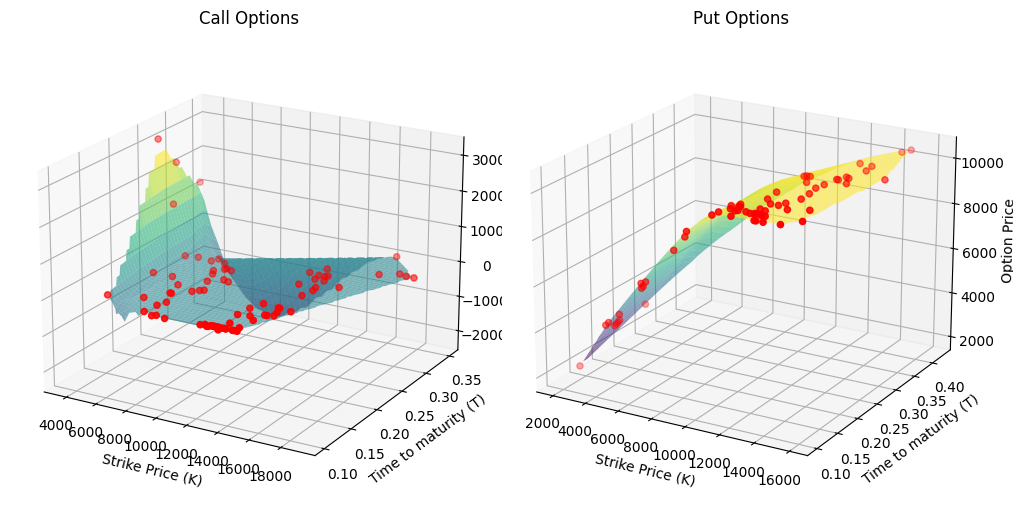

In [3]:
import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.interpolate import griddata

# Read the data
file_path = 'best_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

# Calculate time to expiration
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Calculate the market price for both call and put options
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Separate the data into call and put options
call_options = options_data[options_data['PUTCALLIND'] == 'CALL']
put_options = options_data[options_data['PUTCALLIND'] == 'PUT ']

# Define the variables for Strike Prices and Time to Maturity for calls and puts
K_call, T_call = call_options['STRIKE_PRC'].values, call_options['T'].values
K_put, T_put = put_options['STRIKE_PRC'].values, put_options['T'].values

# Create a mesh grid for T and K for calls and puts
K_grid_call, T_grid_call = np.meshgrid(np.linspace(min(K_call), max(K_call), 100), np.linspace(min(T_call), max(T_call), 100))
K_grid_put, T_grid_put = np.meshgrid(np.linspace(min(K_put), max(K_put), 100), np.linspace(min(T_put), max(T_put), 100))

# Create a new figure
fig = plt.figure(figsize=(10, 6))

# Create 3D plots for call options
ax1 = fig.add_subplot(121, projection='3d')
model_price_grid_call = griddata((K_call, T_call), call_options['MODEL_PRICE'], (K_grid_call, T_grid_call), method='cubic')
ax1.plot_surface(K_grid_call, T_grid_call, model_price_grid_call, cmap='viridis', alpha=0.6)
ax1.scatter(K_call, T_call, call_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax1.set_title('Call Options')
ax1.set_xlabel('Strike Price (K)')
ax1.set_ylabel('Time to maturity (T)')
ax1.set_zlabel('Option Price', rotation=90)
ax1.view_init(20, -60)  # Adjust the viewing angle for better visualization

# Create 3D plots for put options
ax2 = fig.add_subplot(122, projection='3d')
model_price_grid_put = griddata((K_put, T_put), put_options['MODEL_PRICE'], (K_grid_put, T_grid_put), method='cubic')
ax2.plot_surface(K_grid_put, T_grid_put, model_price_grid_put, cmap='viridis', alpha=0.6)
ax2.scatter(K_put, T_put, put_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax2.set_title('Put Options')
ax2.set_xlabel('Strike Price (K)')
ax2.set_ylabel('Time to maturity (T)')
ax2.set_zlabel('Option Price', rotation=90)
ax2.view_init(20, -60)  # Adjust the viewing angle for better visualization

plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

# Read the data
file_path = 'best_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

#Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Define a threshold for what is considered a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Extract relevant columns
result = options_data[['PUTCALLIND', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'OUTSIDE_THRESHOLD']]

print(result)

# Export the DataFrame to a CSV file
result.to_csv('best_optimal_options_with_errors.csv', index=False)


    PUTCALLIND  IMP_VOLT  PERCENTAGE_ERROR  OUTSIDE_THRESHOLD
1         PUT      23.35          0.010419              False
2         PUT      23.36          0.009281              False
3         PUT      23.41          0.010378              False
4         PUT      23.50          0.009570              False
5         PUT      23.57          0.010913              False
..         ...       ...               ...                ...
147       CALL    105.36          3.492179              False
148       CALL    107.54          2.988164              False
149       CALL    118.17          1.782966              False
150       CALL    130.77          1.191327              False
151       PUT     150.50          0.009173              False

[151 rows x 4 columns]


In [7]:
import numpy as np
import pandas as pd

# Read the data
file_path = 'best_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Replace 'inf' percentage error with None for CALL options
options_data.loc[(options_data['PUTCALLIND'] == 'CALL') & (options_data['PERCENTAGE_ERROR'] == np.inf), 'PERCENTAGE_ERROR'] = None

# Define a threshold for what you consider a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Count the number of 'CALL' and 'PUT' options within the threshold
num_calls_within_threshold = len(options_data[(options_data['PUTCALLIND'] == 'CALL') & (options_data['OUTSIDE_THRESHOLD'] == False)])
num_puts_within_threshold = len(options_data[(options_data['PUTCALLIND'] == 'PUT ') & (options_data['OUTSIDE_THRESHOLD'] == False)])

print(f"Number of CALL options within threshold: {num_calls_within_threshold}")
print(f"Number of PUT options within threshold: {num_puts_within_threshold}")


Number of CALL options within threshold: 84
Number of PUT options within threshold: 67


In [4]:
import pandas as pd
import plotly.express as px

# Read the data
file_path = 'best_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Correct infinite percentage errors due to division by zero
options_data.loc[options_data['PERCENTAGE_ERROR'] == float('inf'), 'PERCENTAGE_ERROR'] = None

# Define a threshold for what you consider a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Create a new column combining option type and threshold status
options_data['OPTION_STATUS'] = options_data.apply(lambda row: row['PUTCALLIND'].strip() + (' Outside' if row['OUTSIDE_THRESHOLD'] else ' Inside'), axis=1)

# Extract relevant columns
result = options_data[['OPTION_STATUS', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'MODEL_PRICE']]

# Create a scatter plot with facets
fig = px.scatter(result,
                 x='MODEL_PRICE',
                 y='IMP_VOLT',
                 color='PERCENTAGE_ERROR',
                 facet_col='OPTION_STATUS',
                 title='Option Prices vs. Implied Volatility',
                 labels={'MODEL_PRICE': 'Option Price', 'IMP_VOLT': 'Implied Volatility', 'OPTION_STATUS': 'Option Type & Status'},
                 color_continuous_scale='viridis',
                 hover_data=['OPTION_STATUS', 'PERCENTAGE_ERROR'])

# Modify the marker aesthetics
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# Update facet titles
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

# Show the plot
fig.show()


**Step 2:** This looks promising, so I try using the calibrated parameters on the whole dataset.

In [9]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.integrate import quad
from scipy.optimize import minimize

# Characteristic function for the CIR process
@njit
def CIR_char_func(u, T, kappa, theta, sigma_r, r0):
    gamma = np.sqrt(kappa**2 + 2*sigma_r**2*u*1j)
    A = 2*gamma*np.exp((kappa+gamma)*T/2) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    B = 2*(np.exp(gamma*T)-1) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    char_func_value = np.exp(A*theta-B*r0)
    return char_func_value

# Modified Valuation of European call option in BCC97 model via Lewis (2001)
@njit
def BCC_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    CIR1 = CIR_char_func(u, T, kappa, theta, sigma_r, r0)
    BCC1 = H93_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0)
    BCC2 = M76_char_func(u, T, lamb, mu, delta)
    jumpVolatilityPart = lamb * (np.exp(1j * u * muV * deltaV) - 1) * T
    return CIR1 * BCC1 * BCC2 * np.exp(jumpVolatilityPart * rhoJ)

# Valuation of European call option in H93 model via Lewis (2001)
@njit
def H93_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v ** 2 * (-u * 1j - u ** 2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = (r0 * u * 1j * T + (c1 / sigma_v ** 2) * ((kappa_v - rho * sigma_v * u * 1j + c2) * T - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))))
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v ** 2 * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

# Valuation of European call option in M76 model via Lewis (2001)
@njit
def M76_char_func(u, T, lamb, mu, delta):
    omega = -lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp((1j * u * omega + lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return char_func_value

# Integration function for BCC97 model
@njit
def BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    char_func_value = BCC_char_func(u - 1j * 0.5, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ)
    int_func_value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value

# BCC model's call option valuation
def BCC_call_value(S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    int_value = quad(lambda u: BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ), 0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r0 * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

# Read the data
file_path = 'sorted_options_data.csv'
options_data = pd.read_csv(file_path)

# Separate the underlying and option data
underlying_data = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the time to maturity for each option
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Initial interest rate
r0 = -0.00067

# Define the objective function to accommodate the stochastic interest rate
def objective(params, option_type, options_data):
    kappa, theta, sigma_r, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ = params
    sum_squared_errors = 0
    for idx, row in options_data.iterrows():
        if row['PUTCALLIND'] == option_type:
            model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                         kappa=kappa, theta=theta, sigma_r=sigma_r, r0=r0,
                                         kappa_v=kappa_v, theta_v=theta_v, sigma_v=sigma_v, rho=rho, v0=v0,
                                         lamb=lamb, mu=mu, delta=delta, muV=muV, deltaV=deltaV, rhoJ=rhoJ)
            market_price = np.maximum(row['CF_CLOSE'] - row['STRIKE_PRC'], 0) if option_type == 'CALL' else np.maximum(row['STRIKE_PRC'] - row['CF_CLOSE'], 0)
            sum_squared_errors += (model_price - market_price) ** 2
    return sum_squared_errors

# Define the initial parameters
initial_params = [4.0, 0.01, 0.01, r0, 4.0, 0.01, 0.01, 0.5, 0.01, 0.5, 0.0, 0.1, 0.0, 0.1, 0.5]

# Bounds for the parameters
bounds = [(0.1, 10),    # kappa
    (0.001, 0.03), # theta
    (0.001, 0.03), # sigma_r
    (-0.01, 0.01), # r0
    (0.1, 10),    # kappa_v
    (0.001, 0.03), # theta_v
    (0.001, 0.03), # sigma_v
    (-1, 1),      # rho
    (0, 0.1),     # v0
    (0, 2),       # lamb
    (-1, 1),      # mu
    (0, 1),       # delta
    (-1, 1),      # muV
    (0, 1),       # deltaV
    (-1, 1)       # rhoJ
]

# Selecting options in a specific range for demonstration
options_in_range = options_data.copy()

# Price the options using the initial parameters
for idx, row in options_in_range.iterrows():
    if row['PUTCALLIND'] == 'CALL':
        model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                     r0=initial_params[3], kappa_v=initial_params[4], theta_v=initial_params[5],
                                     sigma_v=initial_params[6], rho=initial_params[7], v0=initial_params[8],
                                     lamb=initial_params[9], mu=initial_params[10], delta=initial_params[11],
                                     kappa=initial_params[0], theta=initial_params[1], sigma_r=initial_params[2],
                                     muV=initial_params[12], deltaV=initial_params[13], rhoJ=initial_params[14])
    else:
        call_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r0=initial_params[3],
                                    kappa=initial_params[0], theta=initial_params[1], sigma_r=initial_params[2],
                                    kappa_v=initial_params[4], theta_v=initial_params[5], sigma_v=initial_params[6], rho=initial_params[7], v0=initial_params[8],
                                    lamb=initial_params[9], mu=initial_params[10], delta=initial_params[11], muV=initial_params[12], deltaV=initial_params[13], rhoJ=initial_params[14])
        model_price = call_price + row['STRIKE_PRC']*np.exp(-r0*row['T']) - row['CF_CLOSE']

    options_in_range.loc[idx, 'MODEL_PRICE'] = model_price

options_in_range

# Calculate the market price for both call and put options
options_in_range['MARKET_PRICE'] = 0
options_in_range.loc[options_in_range['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_in_range.loc[options_in_range['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_in_range.loc[options_in_range['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_in_range.loc[options_in_range['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Print the options data with model prices and market prices
print(options_in_range)
data = options_in_range
data.to_csv('all_optimal_options_data.csv', index=False)


     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
1           233  /GDAX118000F0.EX  2020-05-15  2020-06-19       CALL   
2           231  /GDAX117500F0.EX  2020-05-15  2020-06-19       CALL   
3           235  /GDAX118500F0.EX  2020-05-14  2020-06-19       CALL   
4           237  /GDAX119000F0.EX  2020-05-14  2020-06-19       CALL   
5           229  /GDAX117000F0.EX  2020-05-15  2020-06-19       CALL   
..          ...               ...         ...         ...        ...   
374           7   /GDAX41000F0.EX  2020-05-15  2020-06-19       CALL   
375           5   /GDAX40000F0.EX  2020-03-09  2020-06-19       CALL   
376           3   /GDAX36000F0.EX  2020-03-17  2020-06-19       CALL   
377           2   /GDAX20000R0.EX  2020-04-30  2020-06-19       PUT    
378           1   /GDAX20000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT         T  MODEL_PRICE  MARKET_PRICE  
1       11800.0      12.2     23.22  0.095825     0.000000  

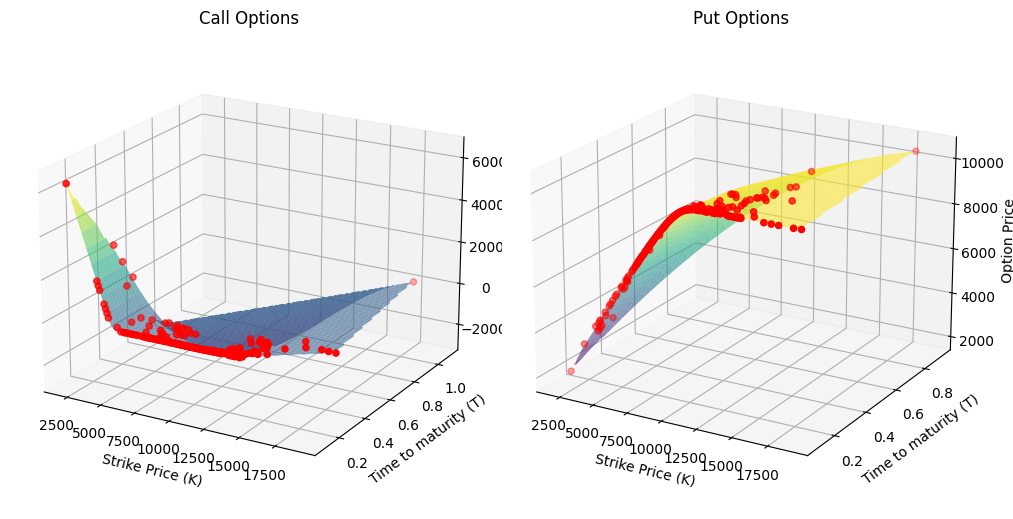

In [10]:
import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.interpolate import griddata

# Read the data
file_path = 'all_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

# Calculate time to expiration
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Calculate the market price for both call and put options
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Separate the data into call and put options
call_options = options_data[options_data['PUTCALLIND'] == 'CALL']
put_options = options_data[options_data['PUTCALLIND'] == 'PUT ']

# Define the variables for Strike Prices and Time to Maturity for calls and puts
K_call, T_call = call_options['STRIKE_PRC'].values, call_options['T'].values
K_put, T_put = put_options['STRIKE_PRC'].values, put_options['T'].values

# Create a mesh grid for T and K for calls and puts
K_grid_call, T_grid_call = np.meshgrid(np.linspace(min(K_call), max(K_call), 100), np.linspace(min(T_call), max(T_call), 100))
K_grid_put, T_grid_put = np.meshgrid(np.linspace(min(K_put), max(K_put), 100), np.linspace(min(T_put), max(T_put), 100))

# Create a new figure
fig = plt.figure(figsize=(10, 6))

# Create 3D plots for call options
ax1 = fig.add_subplot(121, projection='3d')
model_price_grid_call = griddata((K_call, T_call), call_options['MODEL_PRICE'], (K_grid_call, T_grid_call), method='cubic')
ax1.plot_surface(K_grid_call, T_grid_call, model_price_grid_call, cmap='viridis', alpha=0.6)
ax1.scatter(K_call, T_call, call_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax1.set_title('Call Options')
ax1.set_xlabel('Strike Price (K)')
ax1.set_ylabel('Time to maturity (T)')
ax1.set_zlabel('Option Price', rotation=90)
ax1.view_init(20, -60)  # Adjust the viewing angle for better visualization

# Create 3D plots for put options
ax2 = fig.add_subplot(122, projection='3d')
model_price_grid_put = griddata((K_put, T_put), put_options['MODEL_PRICE'], (K_grid_put, T_grid_put), method='cubic')
ax2.plot_surface(K_grid_put, T_grid_put, model_price_grid_put, cmap='viridis', alpha=0.6)
ax2.scatter(K_put, T_put, put_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax2.set_title('Put Options')
ax2.set_xlabel('Strike Price (K)')
ax2.set_ylabel('Time to maturity (T)')
ax2.set_zlabel('Option Price', rotation=90)
ax2.view_init(20, -60)  # Adjust the viewing angle for better visualization

plt.tight_layout()
plt.show()


In [44]:
import pandas as pd

# Read the data
file_path = 'all_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

#Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Define a threshold for what is considered a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Extract relevant columns
result = options_data[['PUTCALLIND', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'OUTSIDE_THRESHOLD']]

print(result)

# Export the DataFrame to a CSV file
result.to_csv('all_optimal_options_with_errors.csv', index=False)


    PUTCALLIND  IMP_VOLT  PERCENTAGE_ERROR  OUTSIDE_THRESHOLD
1         CALL     23.23               NaN              False
2         CALL     23.23               NaN              False
3         CALL     23.25               NaN              False
4         CALL     23.26               NaN              False
5         CALL     23.32               NaN              False
..         ...       ...               ...                ...
373       CALL    115.42          1.964282              False
374       CALL    118.17          1.782966              False
375       CALL    130.77          1.191327              False
376       PUT     150.50          0.009173              False
377       CALL    203.25          0.321632              False

[377 rows x 4 columns]


In [13]:
import numpy as np
import pandas as pd

# Read the data
file_path = 'all_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Replace 'inf' percentage error with None for CALL options
options_data.loc[(options_data['PUTCALLIND'] == 'CALL') & (options_data['PERCENTAGE_ERROR'] == np.inf), 'PERCENTAGE_ERROR'] = None

# Define a threshold for what you consider a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Count the number of 'CALL' and 'PUT' options within the threshold
num_calls_within_threshold = len(options_data[(options_data['PUTCALLIND'] == 'CALL') & (options_data['OUTSIDE_THRESHOLD'] == False)])
num_puts_within_threshold = len(options_data[(options_data['PUTCALLIND'] == 'PUT ') & (options_data['OUTSIDE_THRESHOLD'] == False)])

print(f"Number of CALL options within threshold: {num_calls_within_threshold}")
print(f"Number of PUT options within threshold: {num_puts_within_threshold}")


Number of CALL options within threshold: 185
Number of PUT options within threshold: 189


In [14]:
import pandas as pd
import plotly.express as px

# Read the data
file_path = 'all_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Correct infinite percentage errors due to division by zero
options_data.loc[options_data['PERCENTAGE_ERROR'] == float('inf'), 'PERCENTAGE_ERROR'] = None

# Define a threshold for what you consider a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Create a new column combining option type and threshold status
options_data['OPTION_STATUS'] = options_data.apply(lambda row: row['PUTCALLIND'].strip() + (' Outside' if row['OUTSIDE_THRESHOLD'] else ' Inside'), axis=1)

# Extract relevant columns
result = options_data[['OPTION_STATUS', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'MODEL_PRICE']]

# Create a scatter plot with facets
fig = px.scatter(result,
                 x='MODEL_PRICE',
                 y='IMP_VOLT',
                 color='PERCENTAGE_ERROR',
                 facet_col='OPTION_STATUS',
                 title='Option Prices vs. Implied Volatility',
                 labels={'MODEL_PRICE': 'Option Price', 'IMP_VOLT': 'Implied Volatility', 'OPTION_STATUS': 'Option Type & Status'},
                 color_continuous_scale='viridis',
                 hover_data=['OPTION_STATUS', 'PERCENTAGE_ERROR'])

# Modify the marker aesthetics
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# Update facet titles
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

# Show the plot
fig.show()


**Step 3:** There are three call options that have a percentage error exceeding 5%, so I will recalibrate the model and try the new parameters on the entire dataset to see if I can get that percentage error down, to below 5%.

In [23]:
# Read the uploaded data
options_data_updated = pd.read_csv('all_optimal_options_data.csv')

# Calculate the market price for each option
options_data_updated['MARKET_PRICE'] = 0
options_data_updated.loc[options_data_updated['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data_updated.loc[options_data_updated['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data_updated.loc[options_data_updated['PUTCALLIND'] == 'PUT', 'MARKET_PRICE'] = options_data_updated.loc[options_data_updated['PUTCALLIND'] == 'PUT'].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data_updated['PERCENTAGE_ERROR'] = abs((options_data_updated['MODEL_PRICE'] - options_data_updated['MARKET_PRICE']) / options_data_updated['MARKET_PRICE'] * 100)

# Filter call options with percentage error greater than 5%
call_options_with_high_error = options_data_updated[(options_data_updated['PUTCALLIND'] == 'CALL') & (options_data_updated['PERCENTAGE_ERROR'] > 5)]

call_options_with_high_error[['MODEL_PRICE', 'MARKET_PRICE', 'PERCENTAGE_ERROR', 'STRIKE_PRC', 'T']]


,MODEL_PRICE,MARKET_PRICE,PERCENTAGE_ERROR,STRIKE_PRC,T
363,475.620535,523.3,9.111306,4900.0,0.095825
365,675.397483,723.2,6.609861,4800.0,0.095825
366,875.638625,923.0,5.131243,4700.0,0.095825


In [30]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.integrate import quad
from scipy.optimize import minimize

@njit
def CIR_char_func(u, T, kappa, theta, sigma_r, r0):
    gamma = np.sqrt(kappa**2 + 2*sigma_r**2*u*1j)
    A = 2*gamma*np.exp((kappa+gamma)*T/2) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    B = 2*(np.exp(gamma*T)-1) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    char_func_value = np.exp(A*theta-B*r0)
    return char_func_value

@njit
def H93_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v ** 2 * (-u * 1j - u ** 2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = (r0 * u * 1j * T + (c1 / sigma_v ** 2) * ((kappa_v - rho * sigma_v * u * 1j + c2) * T - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))))
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v ** 2 * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

@njit
def M76_char_func(u, T, lamb, mu, delta):
    omega = -lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp((1j * u * omega + lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return char_func_value


In [31]:
@njit
def BCC_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    CIR1 = CIR_char_func(u, T, kappa, theta, sigma_r, r0)
    BCC1 = H93_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0)
    BCC2 = M76_char_func(u, T, lamb, mu, delta)
    jumpVolatilityPart = lamb * (np.exp(1j * u * muV * deltaV) - 1) * T
    return CIR1 * BCC1 * BCC2 * np.exp(jumpVolatilityPart * rhoJ)

@njit
def BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    char_func_value = BCC_char_func(u - 1j * 0.5, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ)
    int_func_value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value

def BCC_call_value(S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    int_value = quad(lambda u: BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ), 0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r0 * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value


In [32]:
# Read the data
file_path = 'sorted_options_data.csv'
options_data = pd.read_csv(file_path)

# Separate the underlying and option data
underlying_data = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the time to maturity for each option
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Reset the indices
options_data = options_data.reset_index(drop=True)

# Read the uploaded data
options_data_updated = pd.read_csv('all_optimal_options_data.csv')
options_data_updated = options_data_updated.reset_index(drop=True)

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data_updated['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data_updated['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data_updated['PUTCALLIND'] == 'PUT', 'MARKET_PRICE'] = options_data.loc[options_data_updated['PUTCALLIND'] == 'PUT'].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)


In [34]:
# Initial interest rate
r0 = -0.00067

# Adjusting the objective function to accept option type and data arguments
def adjusted_objective(params, option_type, options_data_subset):
    kappa, theta, sigma_r, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ = params
    sum_squared_errors = 0
    for idx, row in options_data_subset.iterrows():
        if row['PUTCALLIND'] == option_type:
            model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                         kappa=kappa, theta=theta, sigma_r=sigma_r, r0=r0,
                                         kappa_v=kappa_v, theta_v=theta_v, sigma_v=sigma_v, rho=rho, v0=v0,
                                         lamb=lamb, mu=mu, delta=delta, muV=muV, deltaV=deltaV, rhoJ=rhoJ)
            market_price = row['MARKET_PRICE']
            sum_squared_errors += (model_price - market_price) ** 2
    return sum_squared_errors

# Define the initial parameters
initial_params = [4.0, 0.01, 0.01, r0, 4.0, 0.01, 0.01, 0.5, 0.01, 0.5, 0.0, 0.1, 0.0, 0.1, 0.5]

# Bounds for the parameters
bounds = [(0.1, 10),    # kappa
    (0.001, 0.03), # theta
    (0.001, 0.03), # sigma_r
    (-0.01, 0.01), # r0
    (0.1, 10),    # kappa_v
    (0.001, 0.03), # theta_v
    (0.001, 0.03), # sigma_v
    (-1, 1),      # rho
    (0, 0.1),     # v0
    (0, 2),       # lamb
    (-1, 1),      # mu
    (0, 1),       # delta
    (-1, 1),      # muV
    (0, 1),       # deltaV
    (-1, 1)       # rhoJ
]

# Compute model prices for all options using initial parameters
options_data['MODEL_PRICE'] = options_data.apply(lambda row: BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                     kappa=initial_params[0], theta=initial_params[1], sigma_r=initial_params[2], r0=initial_params[3],
                                     kappa_v=initial_params[4], theta_v=initial_params[5], sigma_v=initial_params[6], rho=initial_params[7], v0=initial_params[8],
                                     lamb=initial_params[9], mu=initial_params[10], delta=initial_params[11], muV=initial_params[12], deltaV=initial_params[13], rhoJ=initial_params[14]), axis=1)

# Calculate percentage error between the model and market prices for all options
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Filter the data to include only the three specific options with high percentage errors
high_error_options = options_data[options_data['PERCENTAGE_ERROR'] > 5]

# Re-optimize the parameters specifically for the high-error options
result_high_error_optimization = minimize(adjusted_objective, initial_params, args=('CALL', high_error_options), bounds=bounds, method='L-BFGS-B')

# Check if optimization was successful
if result_high_error_optimization.success:
    # Compute the model prices using the optimized parameters for the three specific options
    high_error_options_optimized = high_error_options.copy()
    high_error_options_optimized['MODEL_PRICE_OPTIMIZED'] = high_error_options_optimized.apply(lambda row: BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                         kappa=result_high_error_optimization.x[0], theta=result_high_error_optimization.x[1], sigma_r=result_high_error_optimization.x[2], r0=result_high_error_optimization.x[3],
                                         kappa_v=result_high_error_optimization.x[4], theta_v=result_high_error_optimization.x[5], sigma_v=result_high_error_optimization.x[6], rho=result_high_error_optimization.x[7], v0=result_high_error_optimization.x[8],
                                         lamb=result_high_error_optimization.x[9], mu=result_high_error_optimization.x[10], delta=result_high_error_optimization.x[11], muV=result_high_error_optimization.x[12], deltaV=result_high_error_optimization.x[13], rhoJ=result_high_error_optimization.x[14]), axis=1)

    # Calculate the new percentage error between the model and market prices for these options
    high_error_options_optimized['PERCENTAGE_ERROR_OPTIMIZED'] = abs((high_error_options_optimized['MODEL_PRICE_OPTIMIZED'] - high_error_options_optimized['MARKET_PRICE']) / high_error_options_optimized['MARKET_PRICE'] * 100)
    output = high_error_options_optimized[['MODEL_PRICE', 'MODEL_PRICE_OPTIMIZED', 'MARKET_PRICE', 'PERCENTAGE_ERROR', 'PERCENTAGE_ERROR_OPTIMIZED']]
else:
    output = "Optimization was not successful."

output


,MODEL_PRICE,MODEL_PRICE_OPTIMIZED,MARKET_PRICE,PERCENTAGE_ERROR,PERCENTAGE_ERROR_OPTIMIZED
363,475.620535,523.300026,523.3,9.111306,4.943830e-06
365,675.397483,723.200004,723.2,6.609861,5.464059e-07
366,875.638625,923.000003,923.0,5.131243,3.246012e-07


In [35]:
# Initial interest rate
r0 = -0.00067

# Adjusting the objective function to accept option type and data arguments
def adjusted_objective(params, option_type, options_data_subset):
    kappa, theta, sigma_r, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ = params
    sum_squared_errors = 0
    for idx, row in options_data_subset.iterrows():
        if row['PUTCALLIND'] == option_type:
            model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                         kappa=kappa, theta=theta, sigma_r=sigma_r, r0=r0,
                                         kappa_v=kappa_v, theta_v=theta_v, sigma_v=sigma_v, rho=rho, v0=v0,
                                         lamb=lamb, mu=mu, delta=delta, muV=muV, deltaV=deltaV, rhoJ=rhoJ)
            market_price = row['MARKET_PRICE']
            sum_squared_errors += (model_price - market_price) ** 2
    return sum_squared_errors

# Define the initial parameters
initial_params = [4.0, 0.01, 0.01, r0, 4.0, 0.01, 0.01, 0.5, 0.01, 0.5, 0.0, 0.1, 0.0, 0.1, 0.5]

# Bounds for the parameters
bounds = [(0.1, 10),    # kappa
    (0.001, 0.03), # theta
    (0.001, 0.03), # sigma_r
    (-0.01, 0.01), # r0
    (0.1, 10),    # kappa_v
    (0.001, 0.03), # theta_v
    (0.001, 0.03), # sigma_v
    (-1, 1),      # rho
    (0, 0.1),     # v0
    (0, 2),       # lamb
    (-1, 1),      # mu
    (0, 1),       # delta
    (-1, 1),      # muV
    (0, 1),       # deltaV
    (-1, 1)       # rhoJ
]

# Compute model prices for all options using initial parameters
options_data['MODEL_PRICE'] = options_data.apply(lambda row: BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                     kappa=initial_params[0], theta=initial_params[1], sigma_r=initial_params[2], r0=initial_params[3],
                                     kappa_v=initial_params[4], theta_v=initial_params[5], sigma_v=initial_params[6], rho=initial_params[7], v0=initial_params[8],
                                     lamb=initial_params[9], mu=initial_params[10], delta=initial_params[11], muV=initial_params[12], deltaV=initial_params[13], rhoJ=initial_params[14]), axis=1)

# Calculate percentage error between the model and market prices for all options
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Filter the data to include only the three specific options with high percentage errors
high_error_options = options_data[options_data['PERCENTAGE_ERROR'] > 5]

# Optimize the parameters specifically for the high-error options
result_high_error_optimization = minimize(adjusted_objective, initial_params, args=('CALL', high_error_options), bounds=bounds, method='L-BFGS-B')

# Check if optimization was successful and display the optimized parameters
if result_high_error_optimization.success:
    optimized_params = result_high_error_optimization.x
    print("Optimized Parameters:", optimized_params)
else:
    print("Optimization was not successful.")

# Compute the model prices using the optimized parameters for the high-error options
high_error_options['MODEL_PRICE_OPTIMIZED'] = high_error_options.apply(lambda row: BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                     kappa=optimized_params[0], theta=optimized_params[1], sigma_r=optimized_params[2], r0=optimized_params[3],
                                     kappa_v=optimized_params[4], theta_v=optimized_params[5], sigma_v=optimized_params[6], rho=optimized_params[7], v0=optimized_params[8],
                                     lamb=optimized_params[9], mu=optimized_params[10], delta=optimized_params[11], muV=optimized_params[12], deltaV=optimized_params[13], rhoJ=optimized_params[14]), axis=1)

# Calculate the new percentage error between the model and market prices for these options
high_error_options['PERCENTAGE_ERROR_OPTIMIZED'] = abs((high_error_options['MODEL_PRICE_OPTIMIZED'] - high_error_options['MARKET_PRICE']) / high_error_options['MARKET_PRICE'] * 100)

# Extracting only the relevant columns for the three specific options
output = high_error_options[['MODEL_PRICE', 'MODEL_PRICE_OPTIMIZED', 'MARKET_PRICE', 'PERCENTAGE_ERROR', 'PERCENTAGE_ERROR_OPTIMIZED']]
print(output)


Optimized Parameters: [3.76807610e+00 1.00000000e-03 8.77986615e-03 5.67355018e-03
 4.16586532e+00 2.29651712e-03 1.14133804e-02 5.03063522e-01
 0.00000000e+00 3.95979221e-01 7.10854746e-02 4.01539560e-02
 6.99623759e-02 9.99763692e-02 5.00002718e-01]
     MODEL_PRICE  MODEL_PRICE_OPTIMIZED  MARKET_PRICE  PERCENTAGE_ERROR  \
363   475.620535             523.300026         523.3          9.111306   
365   675.397483             723.200004         723.2          6.609861   
366   875.638625             923.000003         923.0          5.131243   

     PERCENTAGE_ERROR_OPTIMIZED  
363                4.943830e-06  
365                5.464059e-07  
366                3.246012e-07  


<ipython-input-35-8b0f79a64de6>:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-35-8b0f79a64de6>:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
# We'll sample a subset of the options data for faster computation and demonstration purposes
sample_options_data = options_data.sample(frac=0.1, random_state=42).copy()

# Price the options using the optimized parameters on the sampled data
for idx, row in sample_options_data.iterrows():
    if row['PUTCALLIND'] == 'CALL':
        model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                     r0=optimized_params[3], kappa_v=optimized_params[4], theta_v=optimized_params[5],
                                     sigma_v=optimized_params[6], rho=optimized_params[7], v0=optimized_params[8],
                                     lamb=optimized_params[9], mu=optimized_params[10], delta=optimized_params[11],
                                     kappa=optimized_params[0], theta=optimized_params[1], sigma_r=optimized_params[2],
                                     muV=optimized_params[12], deltaV=optimized_params[13], rhoJ=optimized_params[14])
    else:
        call_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r0=optimized_params[3],
                                    kappa=optimized_params[0], theta=optimized_params[1], sigma_r=optimized_params[2],
                                    kappa_v=optimized_params[4], theta_v=optimized_params[5], sigma_v=optimized_params[6], rho=optimized_params[7], v0=optimized_params[8],
                                    lamb=optimized_params[9], mu=optimized_params[10], delta=optimized_params[11], muV=optimized_params[12], deltaV=optimized_params[13], rhoJ=optimized_params[14])
        model_price = call_price + row['STRIKE_PRC']*np.exp(-optimized_params[3]*row['T']) - row['CF_CLOSE']

    sample_options_data.loc[idx, 'MODEL_PRICE'] = model_price

# Calculate the market price for both call and put options
sample_options_data['MARKET_PRICE'] = 0
sample_options_data.loc[sample_options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = sample_options_data.loc[sample_options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
sample_options_data.loc[sample_options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = sample_options_data.loc[sample_options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

sample_options_data.head()


<ipython-input-31-2642fdebd747>:16: IntegrationWarning:

The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



,Unnamed: 0,Instrument,CF_DATE,EXPIR_DATE,PUTCALLIND,STRIKE_PRC,CF_CLOSE,IMP_VOLT,T,MARKET_PRICE,MODEL_PRICE,PERCENTAGE_ERROR
287,85,/GDAX81000F0.EX,2020-04-22,2020-06-19,CALL,8100.0,2275.4,54.33,0.158795,0.0,0.000000,NaN
329,46,/GDAX66000R0.EX,2020-05-06,2020-06-19,PUT,6600.0,13.6,68.11,0.120465,6586.4,6581.890661,NaN
323,374,/GDAX180000R0.EX,2019-07-18,2020-06-19,PUT,18000.0,7689.0,65.37,0.922656,10311.0,10217.020989,NaN
145,306,/GDAX136000R0.EX,2020-03-24,2020-06-19,PUT,13600.0,3286.0,32.97,0.238193,10314.0,10295.633373,NaN
55,267,/GDAX126500F0.EX,2020-05-12,2020-06-19,CALL,12650.0,1.7,25.67,0.104038,0.0,0.000000,NaN


In [38]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.integrate import quad
from scipy.optimize import minimize

@njit
def CIR_char_func(u, T, kappa, theta, sigma_r, r0):
    gamma = np.sqrt(kappa**2 + 2*sigma_r**2*u*1j)
    A = 2*gamma*np.exp((kappa+gamma)*T/2) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    B = 2*(np.exp(gamma*T)-1) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    char_func_value = np.exp(A*theta-B*r0)
    return char_func_value

@njit
def H93_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v ** 2 * (-u * 1j - u ** 2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = (r0 * u * 1j * T + (c1 / sigma_v ** 2) * ((kappa_v - rho * sigma_v * u * 1j + c2) * T - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))))
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v ** 2 * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

@njit
def M76_char_func(u, T, lamb, mu, delta):
    omega = -lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp((1j * u * omega + lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return char_func_value

@njit
def BCC_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    CIR1 = CIR_char_func(u, T, kappa, theta, sigma_r, r0)
    BCC1 = H93_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0)
    BCC2 = M76_char_func(u, T, lamb, mu, delta)
    jumpVolatilityPart = lamb * (np.exp(1j * u * muV * deltaV) - 1) * T
    return CIR1 * BCC1 * BCC2 * np.exp(jumpVolatilityPart * rhoJ)

@njit
def BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    char_func_value = BCC_char_func(u - 1j * 0.5, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ)
    int_func_value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value

def BCC_call_value(S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    int_value = quad(lambda u: BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ), 0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r0 * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

# Read the data
file_path = 'sorted_options_data.csv'
options_data = pd.read_csv(file_path)

# Separate the underlying and option data
underlying_data = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the time to maturity for each option
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Reset the indices
options_data = options_data.reset_index(drop=True)

# Read the uploaded data
options_data_updated = pd.read_csv('all_optimal_options_data.csv')
options_data_updated = options_data_updated.reset_index(drop=True)

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data_updated['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data_updated['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data_updated['PUTCALLIND'] == 'PUT', 'MARKET_PRICE'] = options_data.loc[options_data_updated['PUTCALLIND'] == 'PUT'].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Initial interest rate
r0 = -0.00067

# Define the objective function to accommodate the stochastic interest rate
def objective(params, option_type, options_data):
    kappa, theta, sigma_r, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ = params
    sum_squared_errors = 0
    for idx, row in options_data.iterrows():
        if row['PUTCALLIND'] == option_type:
            model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                         kappa=kappa, theta=theta, sigma_r=sigma_r, r0=r0,
                                         kappa_v=kappa_v, theta_v=theta_v, sigma_v=sigma_v, rho=rho, v0=v0,
                                         lamb=lamb, mu=mu, delta=delta, muV=muV, deltaV=deltaV, rhoJ=rhoJ)
            market_price = np.maximum(row['CF_CLOSE'] - row['STRIKE_PRC'], 0) if option_type == 'CALL' else np.maximum(row['STRIKE_PRC'] - row['CF_CLOSE'], 0)
            sum_squared_errors += (model_price - market_price) ** 2
    return sum_squared_errors

# Define the initial parameters
initial_params = [3.76807610e+00, 1.00000000e-03, 8.77986615e-03, 5.67355018e-03,
 4.16586532e+00, 2.29651712e-03, 1.14133804e-02, 5.03063522e-01,
 0.00000000e+00, 3.95979221e-01, 7.10854746e-02, 4.01539560e-02,
 6.99623759e-02, 9.99763692e-02, 5.00002718e-01]

# Bounds for the parameters
bounds = [(0.1, 10),    # kappa
    (0.001, 0.03), # theta
    (0.001, 0.03), # sigma_r
    (-0.01, 0.01), # r0
    (0.1, 10),    # kappa_v
    (0.001, 0.03), # theta_v
    (0.001, 0.03), # sigma_v
    (-1, 1),      # rho
    (0, 0.1),     # v0
    (0, 2),       # lamb
    (-1, 1),      # mu
    (0, 1),       # delta
    (-1, 1),      # muV
    (0, 1),       # deltaV
    (-1, 1)       # rhoJ
]

# Selecting options in a specific range for demonstration
options_in_range = options_data.copy()

# Price the options using the initial parameters
for idx, row in options_in_range.iterrows():
    if row['PUTCALLIND'] == 'CALL':
        model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                     r0=initial_params[3], kappa_v=initial_params[4], theta_v=initial_params[5],
                                     sigma_v=initial_params[6], rho=initial_params[7], v0=initial_params[8],
                                     lamb=initial_params[9], mu=initial_params[10], delta=initial_params[11],
                                     kappa=initial_params[0], theta=initial_params[1], sigma_r=initial_params[2],
                                     muV=initial_params[12], deltaV=initial_params[13], rhoJ=initial_params[14])
    else:
        call_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r0=initial_params[3],
                                    kappa=initial_params[0], theta=initial_params[1], sigma_r=initial_params[2],
                                    kappa_v=initial_params[4], theta_v=initial_params[5], sigma_v=initial_params[6], rho=initial_params[7], v0=initial_params[8],
                                    lamb=initial_params[9], mu=initial_params[10], delta=initial_params[11], muV=initial_params[12], deltaV=initial_params[13], rhoJ=initial_params[14])
        model_price = call_price + row['STRIKE_PRC']*np.exp(-r0*row['T']) - row['CF_CLOSE']

    options_in_range.loc[idx, 'MODEL_PRICE'] = model_price

options_in_range

# Calculate the market price for both call and put options
options_in_range['MARKET_PRICE'] = 0
options_in_range.loc[options_in_range['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_in_range.loc[options_in_range['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_in_range.loc[options_in_range['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_in_range.loc[options_in_range['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Print the options data with model prices and market prices
print(options_in_range)
data = options_in_range
data.to_csv('simply_optimal_options_data.csv', index=False)

<ipython-input-38-ce294fe75e43>:46: IntegrationWarning:

The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

<ipython-input-38-ce294fe75e43>:46: IntegrationWarning:

The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0           233  /GDAX118000F0.EX  2020-05-15  2020-06-19       CALL   
1           231  /GDAX117500F0.EX  2020-05-15  2020-06-19       CALL   
2           235  /GDAX118500F0.EX  2020-05-14  2020-06-19       CALL   
3           237  /GDAX119000F0.EX  2020-05-14  2020-06-19       CALL   
4           229  /GDAX117000F0.EX  2020-05-15  2020-06-19       CALL   
..          ...               ...         ...         ...        ...   
373           7   /GDAX41000F0.EX  2020-05-15  2020-06-19       CALL   
374           5   /GDAX40000F0.EX  2020-03-09  2020-06-19       CALL   
375           3   /GDAX36000F0.EX  2020-03-17  2020-06-19       CALL   
376           2   /GDAX20000R0.EX  2020-04-30  2020-06-19       PUT    
377           1   /GDAX20000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT         T  MARKET_PRICE  MODEL_PRICE  
0       11800.0      12.2     23.22  0.095825           0.0 

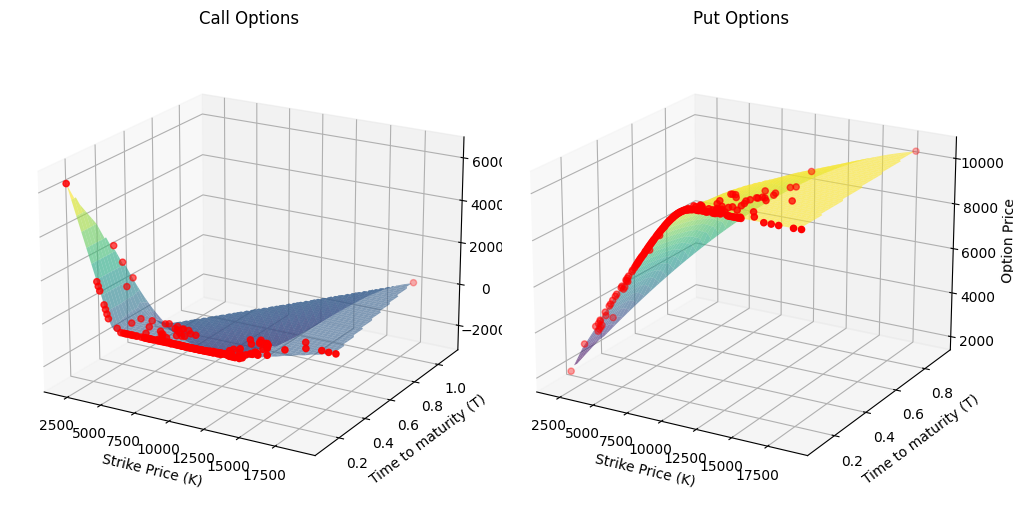

In [39]:
import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.interpolate import griddata

# Read the data
file_path = 'simply_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

# Calculate time to expiration
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Calculate the market price for both call and put options
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Separate the data into call and put options
call_options = options_data[options_data['PUTCALLIND'] == 'CALL']
put_options = options_data[options_data['PUTCALLIND'] == 'PUT ']

# Define the variables for Strike Prices and Time to Maturity for calls and puts
K_call, T_call = call_options['STRIKE_PRC'].values, call_options['T'].values
K_put, T_put = put_options['STRIKE_PRC'].values, put_options['T'].values

# Create a mesh grid for T and K for calls and puts
K_grid_call, T_grid_call = np.meshgrid(np.linspace(min(K_call), max(K_call), 100), np.linspace(min(T_call), max(T_call), 100))
K_grid_put, T_grid_put = np.meshgrid(np.linspace(min(K_put), max(K_put), 100), np.linspace(min(T_put), max(T_put), 100))

# Create a new figure
fig = plt.figure(figsize=(10, 6))

# Create 3D plots for call options
ax1 = fig.add_subplot(121, projection='3d')
model_price_grid_call = griddata((K_call, T_call), call_options['MODEL_PRICE'], (K_grid_call, T_grid_call), method='cubic')
ax1.plot_surface(K_grid_call, T_grid_call, model_price_grid_call, cmap='viridis', alpha=0.6)
ax1.scatter(K_call, T_call, call_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax1.set_title('Call Options')
ax1.set_xlabel('Strike Price (K)')
ax1.set_ylabel('Time to maturity (T)')
ax1.set_zlabel('Option Price', rotation=90)
ax1.view_init(20, -60)  # Adjust the viewing angle for better visualization

# Create 3D plots for put options
ax2 = fig.add_subplot(122, projection='3d')
model_price_grid_put = griddata((K_put, T_put), put_options['MODEL_PRICE'], (K_grid_put, T_grid_put), method='cubic')
ax2.plot_surface(K_grid_put, T_grid_put, model_price_grid_put, cmap='viridis', alpha=0.6)
ax2.scatter(K_put, T_put, put_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax2.set_title('Put Options')
ax2.set_xlabel('Strike Price (K)')
ax2.set_ylabel('Time to maturity (T)')
ax2.set_zlabel('Option Price', rotation=90)
ax2.view_init(20, -60)  # Adjust the viewing angle for better visualization

plt.tight_layout()
plt.show()


In [42]:
import pandas as pd

# Read the data
file_path = 'simply_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

#Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Define a threshold for what is considered a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Extract relevant columns
result = options_data[['PUTCALLIND', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'OUTSIDE_THRESHOLD']]

print(result)

# Export the DataFrame to a CSV file
result.to_csv('simply_optimal_options_with_errors.csv', index=False)


    PUTCALLIND  IMP_VOLT  PERCENTAGE_ERROR  OUTSIDE_THRESHOLD
1         CALL     23.23               NaN              False
2         CALL     23.23               NaN              False
3         CALL     23.25               NaN              False
4         CALL     23.26               NaN              False
5         CALL     23.32               NaN              False
..         ...       ...               ...                ...
373       CALL    115.42      1.853143e-07              False
374       CALL    118.17      2.692213e-01              False
375       CALL    130.77      1.607085e-01              False
376       PUT     150.50      9.172679e-03              False
377       CALL    203.25      3.089877e-08              False

[377 rows x 4 columns]


In [41]:
import numpy as np
import pandas as pd

# Read the data
file_path = 'simply_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Replace 'inf' percentage error with None for CALL options
options_data.loc[(options_data['PUTCALLIND'] == 'CALL') & (options_data['PERCENTAGE_ERROR'] == np.inf), 'PERCENTAGE_ERROR'] = None

# Define a threshold for what you consider a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Count the number of 'CALL' and 'PUT' options within the threshold
num_calls_within_threshold = len(options_data[(options_data['PUTCALLIND'] == 'CALL') & (options_data['OUTSIDE_THRESHOLD'] == False)])
num_puts_within_threshold = len(options_data[(options_data['PUTCALLIND'] == 'PUT ') & (options_data['OUTSIDE_THRESHOLD'] == False)])

print(f"Number of CALL options within threshold: {num_calls_within_threshold}")
print(f"Number of PUT options within threshold: {num_puts_within_threshold}")


Number of CALL options within threshold: 188
Number of PUT options within threshold: 189


In [45]:
import pandas as pd
import plotly.express as px

# Read the data
file_path = 'simply_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Correct infinite percentage errors due to division by zero
options_data.loc[options_data['PERCENTAGE_ERROR'] == float('inf'), 'PERCENTAGE_ERROR'] = None

# Define a threshold for what you consider a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Create a new column combining option type and threshold status
options_data['OPTION_STATUS'] = options_data.apply(lambda row: row['PUTCALLIND'].strip() + (' Outside' if row['OUTSIDE_THRESHOLD'] else ' Inside'), axis=1)

# Extract relevant columns
result = options_data[['OPTION_STATUS', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'MODEL_PRICE']]

# Create a scatter plot with facets
fig = px.scatter(result,
                 x='MODEL_PRICE',
                 y='IMP_VOLT',
                 color='PERCENTAGE_ERROR',
                 facet_col='OPTION_STATUS',
                 title='Option Prices vs. Implied Volatility',
                 labels={'MODEL_PRICE': 'Option Price', 'IMP_VOLT': 'Implied Volatility', 'OPTION_STATUS': 'Option Type & Status'},
                 color_continuous_scale='viridis',
                 hover_data=['OPTION_STATUS', 'PERCENTAGE_ERROR'])

# Modify the marker aesthetics
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# Update facet titles
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

# Show the plot
fig.show()
